## Compare Autoencoder Results with the PCA/KPCA method

### Imports

In [12]:
import sys 
sys.path.append('../src') 
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy
import os
# from importlib import reload

#### Setup device

In [2]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

### 4roll data

In [3]:

# Prepare the shape of the input for running in the Autoencoder
def np2torch(X):
    Nt = X.shape[1] # number of snapshots
    X_data = X.reshape((-1,5,Nt))
    X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

    # convert data
    X_torch = torch.from_numpy(X_data)
    return X_torch

def torch2np(X_torch):
    X_data = X_torch.detach().numpy()
    X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nt, Nc, Nx) -> (Nx, Nc, Nt)
    Nt = X_data.shape[-1]
    X = X_data.reshape((-1, Nt))
    return X



In [89]:

## Data reading
parameters = [
        (1,4.5,0.1),
        (1,5.0,0.3),
        (1,5.5,0.9),
        (1,7.0,0.3),
        (1,7.5,0.6),
]
# Parameters:
# Re = 1
# Wi = 7.5
# beta = 0.6
Re ,Wi ,beta = parameters[0]
alpha = (1-beta)/(Re*Wi)

dx = 1/2**6
# type of simulation
case = '4roll'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
print('Data shape: ',X.shape)
# Reshape for pytorch NN
X_torch = np2torch(X)
print('Pytorch Input shape: ',X_torch.shape)



#normalize data inside autoencoder
lower_bound = (X_torch.min(dim = 0, keepdim=True)[0].min(dim=2, keepdim=True)[0]).float().to(device)
upper_bound = (X_torch.max(dim = 0, keepdim=True)[0].max(dim=2, keepdim=True)[0]).float().to(device)

Data shape:  (20480, 3998)
Pytorch Input shape:  torch.Size([3998, 5, 4096])


In [90]:
# NN part
latent_dim = 2
autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

autoencoder.load_state_dict(torch.load(f'../Models/Dense_Latent_{latent_dim}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [91]:
# Run test

X_ae_torch = autoencoder(X_torch.float())
X_ae = torch2np(X_ae_torch)

#### Run PCA/KPCA

In [92]:
degree = 1
ncomp = latent_dim

# PCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T

# KPCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = dx, dy = dx) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T

#### Calc Energy

In [93]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = dx, dy = dx)
# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = dx, dy = dx)
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = dx, dy = dx)
# Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = dx, dy = dx)

#### Plot Result

In [94]:
imgdir = f'Images/latent_{latent_dim}'
os.makedirs(imgdir, exist_ok=True)

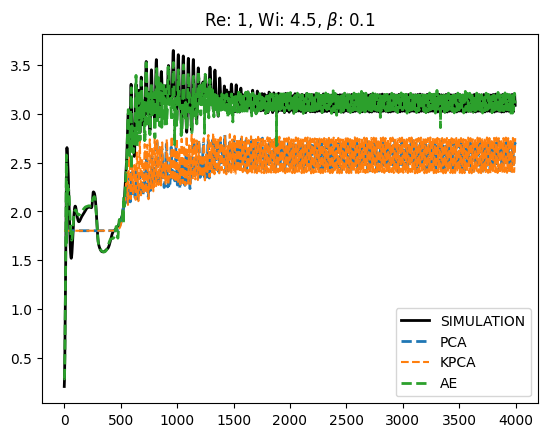

In [95]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
plt.plot(total_ae[ini:fim],'--', label = 'AE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()


plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

### Interpolation test

1 every 3 snaps was removed from trainig dataset

In [119]:

## Data reading
parameters = [
        (1,4.5,0.1), # 0
        (1,5.0,0.3), # 1
        (1,5.5,0.9), # 2
        (1,7.0,0.3), # 3
        (1,7.5,0.6), # 4
]
# Parameters:
# Re = 1
# Wi = 7.5
# beta = 0.6
Re ,Wi ,beta = parameters[4]
alpha = (1-beta)/(Re*Wi)

dx = 1/2**6
# type of simulation
case = '4roll'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
print('Data shape: ',X.shape)
# Reshape for pytorch NN
X_torch = np2torch(X)
print('Pytorch Input shape: ',X_torch.shape)



#normalize data inside autoencoder
lower_bound = (X_torch.min(dim = 0, keepdim=True)[0].min(dim=2, keepdim=True)[0]).float().to(device)
upper_bound = (X_torch.max(dim = 0, keepdim=True)[0].max(dim=2, keepdim=True)[0]).float().to(device)

Data shape:  (20480, 3998)
Pytorch Input shape:  torch.Size([3998, 5, 4096])


In [120]:
# NN part
latent_dim = 3
autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

autoencoder.load_state_dict(torch.load(f'../Models/Dense_Inter_Latent_{latent_dim}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [121]:
# Run test

X_ae_torch = autoencoder(X_torch.float())
X_ae = torch2np(X_ae_torch)

In [122]:
degree = 1

# PCA
ncomp = latent_dim
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T

# KPCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = dx, dy = dx) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T

In [123]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = dx, dy = dx)
# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = dx, dy = dx)
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = dx, dy = dx)
# Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = dx, dy = dx)

In [124]:
imgdir = f'Images/latent_Inter_{latent_dim}'
os.makedirs(imgdir, exist_ok=True)

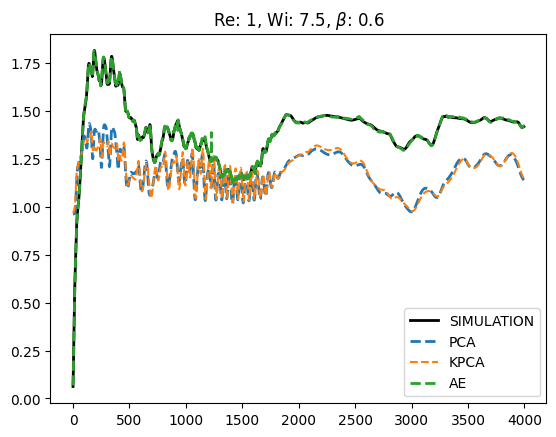

In [125]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
plt.plot(total_ae[ini:fim],'--', label = 'AE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

### Prediction test

lasr 500 snaps was removed from trainig dataset

In [156]:

## Data reading
parameters = [
        (1,4.5,0.1), # 0
        (1,5.0,0.3), # 1
        (1,5.5,0.9), # 2
        (1,7.0,0.3), # 3
        (1,7.5,0.6), # 4
]
# Parameters:
# Re = 1
# Wi = 7.5
# beta = 0.6
Re ,Wi ,beta = parameters[4]
alpha = (1-beta)/(Re*Wi)

dx = 1/2**6
# type of simulation
case = '4roll'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
print('Data shape: ',X.shape)
# Reshape for pytorch NN
X_torch = np2torch(X)
print('Pytorch Input shape: ',X_torch.shape)



#normalize data inside autoencoder
lower_bound = (X_torch.min(dim = 0, keepdim=True)[0].min(dim=2, keepdim=True)[0]).float().to(device)
upper_bound = (X_torch.max(dim = 0, keepdim=True)[0].max(dim=2, keepdim=True)[0]).float().to(device)

Data shape:  (20480, 3998)
Pytorch Input shape:  torch.Size([3998, 5, 4096])


In [157]:
# NN part
latent_dim = 3
autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

autoencoder.load_state_dict(torch.load(f'../Models/Dense_Pred_Latent_{latent_dim}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [158]:
# Run test

X_ae_torch = autoencoder(X_torch.float())
X_ae = torch2np(X_ae_torch)

In [159]:
degree = 1

# PCA
ncomp = latent_dim
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T

# KPCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = dx, dy = dx) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T

In [160]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = dx, dy = dx)
# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = dx, dy = dx)
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = dx, dy = dx)
# Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = dx, dy = dx)

In [161]:
imgdir = f'Images/latent_Pred_{latent_dim}'
os.makedirs(imgdir, exist_ok=True)

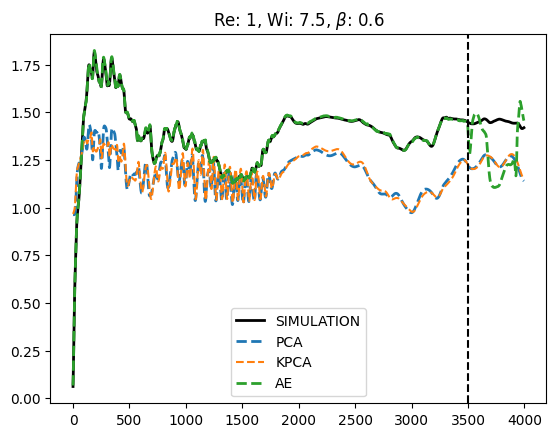

In [162]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
plt.plot(total_ae[ini:fim],'--', label = 'AE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

plt.axvline(len(total) - 500,color = 'k', linestyle='dashed')

plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')